In [3]:
# ## Setup e Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
import gc

warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

print("=" * 70)
print("DIA 6: ENSEMBLE E TUNING DE HIPERPARÂMETROS")
print("=" * 70)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU disponível: {len(tf.config.list_physical_devices('GPU')) > 0}\n")


DIA 6: ENSEMBLE E TUNING DE HIPERPARÂMETROS
TensorFlow: 2.20.0
GPU disponível: True



In [4]:
# ## Diretório

# Se estiver em notebooks/, suba para raiz
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"Mudando para: {os.getcwd()}")

Path('outputs/plots').mkdir(parents=True, exist_ok=True)
Path('outputs/models').mkdir(parents=True, exist_ok=True)
Path('outputs/reports').mkdir(parents=True, exist_ok=True)

print(f"Working directory: {os.getcwd()}\n")

# ## Carregar Dados

print("Carregando dados...")
train = pd.read_csv('data/processed/nyc_taxi_train.csv', parse_dates=['timestamp'])
test = pd.read_csv('data/processed/nyc_taxi_test.csv', parse_dates=['timestamp'])

train = train.head(2000)
print(f"Treino: {len(train)} pontos")
print(f"Teste: {len(test)} pontos\n")

Mudando para: /home/maricarminate/Projetos/anomaly-detector
Working directory: /home/maricarminate/Projetos/anomaly-detector

Carregando dados...
Treino: 2000 pontos
Teste: 874 pontos



In [5]:
# ## Dia 2: Métodos Estatísticos

print("=" * 70)
print("DIA 2: MÉTODOS ESTATÍSTICOS")
print("=" * 70)

# Z-Score
mean_train = train['value'].mean()
std_train = train['value'].std()
z_scores = np.abs((test['value'] - mean_train) / std_train)
zscore_pred = (z_scores > 3).astype(int)
print(f"Z-Score: {zscore_pred.sum()} anomalias")

# IQR
Q1 = train['value'].quantile(0.25)
Q3 = train['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
iqr_pred = ((test['value'] < lower_bound) | (test['value'] > upper_bound)).astype(int)
print(f"IQR: {iqr_pred.sum()} anomalias")

# Moving Average
ma = test['value'].rolling(window=24, center=True).mean()
ma_error = test['value'] - ma
ma_error_std = ma_error.std()
ma_pred = (np.abs(ma_error) > 2 * ma_error_std).astype(int)
ma_pred = ma_pred.fillna(0).astype(int)
print(f"Moving Average: {ma_pred.sum()} anomalias")

# EWMA
ewma = test['value'].ewm(span=24, adjust=False).mean()
ewma_error = test['value'] - ewma
ewma_error_std = ewma_error.std()
ewma_pred = (np.abs(ewma_error) > 2 * ewma_error_std).astype(int)
print(f"EWMA: {ewma_pred.sum()} anomalias\n")


DIA 2: MÉTODOS ESTATÍSTICOS
Z-Score: 0 anomalias
IQR: 0 anomalias
Moving Average: 30 anomalias
EWMA: 34 anomalias



In [6]:
# ## Dia 3: Métodos baseados em Árvores e Distância

print("=" * 70)
print("DIA 3: MÉTODOS BASEADOS EM ÁRVORES E DISTÂNCIA")
print("=" * 70)

# Feature engineering
def create_features(data, window_size=24):
    features = []
    for i in range(window_size, len(data)):
        window = data.iloc[i-window_size:i]['value'].values
        features.append({
            'mean': np.mean(window),
            'std': np.std(window),
            'min': np.min(window),
            'max': np.max(window),
            'range': np.max(window) - np.min(window),
            'current_value': data.iloc[i]['value']
        })
    return pd.DataFrame(features)

train_features = create_features(train, window_size=24)
test_features = create_features(test, window_size=24)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
iso_forest.fit(train_features_scaled)
iso_pred = (iso_forest.predict(test_features_scaled) == -1).astype(int)
print(f"Isolation Forest: {iso_pred.sum()} anomalias")

# LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = (lof.fit_predict(test_features_scaled) == -1).astype(int)
print(f"LOF: {lof_pred.sum()} anomalias")

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_pred = (dbscan.fit_predict(test_features_scaled) == -1).astype(int)
print(f"DBSCAN: {dbscan_pred.sum()} anomalias\n")


DIA 3: MÉTODOS BASEADOS EM ÁRVORES E DISTÂNCIA
Isolation Forest: 96 anomalias
LOF: 43 anomalias
DBSCAN: 0 anomalias



In [7]:
# ## Dia 4: Dense Autoencoder

print("=" * 70)
print("DIA 4: DENSE AUTOENCODER")
print("=" * 70)

seq_len_dense = 10
scaler_dense = MinMaxScaler()
train_scaled = scaler_dense.fit_transform(train[['value']])
test_scaled = scaler_dense.transform(test[['value']])

X_train_dense = np.array([train_scaled[i:i+seq_len_dense] for i in range(len(train_scaled)-seq_len_dense)])
X_test_dense = np.array([test_scaled[i:i+seq_len_dense] for i in range(len(test_scaled)-seq_len_dense)])

gc.collect()
tf.keras.backend.clear_session()

input_dense = layers.Input(shape=(seq_len_dense, 1))
encoder_dense = layers.Flatten()(input_dense)
encoder_dense = layers.Dense(8, activation='relu')(encoder_dense)
encoder_dense = layers.Dense(4, activation='relu', name='latent')(encoder_dense)
decoder_dense = layers.Dense(8, activation='relu')(encoder_dense)
decoder_dense = layers.Dense(seq_len_dense, activation='sigmoid')(decoder_dense)
output_dense = layers.Reshape((seq_len_dense, 1))(decoder_dense)

ae_dense = Model(input_dense, output_dense)
ae_dense.compile(optimizer=Adam(0.001), loss='mse')

print("Treinando Dense Autoencoder...")
ae_dense.fit(X_train_dense, X_train_dense, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

X_train_pred_dense = ae_dense.predict(X_train_dense, verbose=0)
X_test_pred_dense = ae_dense.predict(X_test_dense, verbose=0)

train_mae_dense = np.mean(np.abs(X_train_pred_dense - X_train_dense), axis=(1, 2))
test_mae_dense = np.mean(np.abs(X_test_pred_dense - X_test_dense), axis=(1, 2))

threshold_dense = np.percentile(train_mae_dense, 95)
dense_pred = (test_mae_dense > threshold_dense).astype(int)
dense_pred_aligned = np.concatenate([np.zeros(seq_len_dense), dense_pred])[:len(test)]
print(f"Dense Autoencoder: {dense_pred_aligned.sum()} anomalias\n")

DIA 4: DENSE AUTOENCODER


I0000 00:00:1764364965.141736   27137 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9675 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Treinando Dense Autoencoder...


2025-11-28 18:22:46.766938: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b9600014240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-28 18:22:46.766949: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-11-28 18:22:46.820902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-28 18:22:47.059889: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1764364968.166955   27591 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Dense Autoencoder: 12.0 anomalias



In [8]:
# ## Dia 5: LSTM Autoencoder

print("=" * 70)
print("DIA 5: LSTM AUTOENCODER")
print("=" * 70)

seq_len_lstm = 20
scaler_lstm = MinMaxScaler()
train_scaled_lstm = scaler_lstm.fit_transform(train[['value']])
test_scaled_lstm = scaler_lstm.transform(test[['value']])

X_train_lstm = np.array([train_scaled_lstm[i:i+seq_len_lstm] for i in range(len(train_scaled_lstm)-seq_len_lstm)])
X_test_lstm = np.array([test_scaled_lstm[i:i+seq_len_lstm] for i in range(len(test_scaled_lstm)-seq_len_lstm)])

gc.collect()
tf.keras.backend.clear_session()

input_lstm = layers.Input(shape=(seq_len_lstm, 1))
encoder_lstm = layers.LSTM(32, activation='relu', return_sequences=True)(input_lstm)
encoder_lstm = layers.LSTM(16, activation='relu', return_sequences=False, name='latent')(encoder_lstm)
decoder_lstm = layers.RepeatVector(seq_len_lstm)(encoder_lstm)
decoder_lstm = layers.LSTM(16, activation='relu', return_sequences=True)(decoder_lstm)
decoder_lstm = layers.LSTM(32, activation='relu', return_sequences=True)(decoder_lstm)
output_lstm = layers.TimeDistributed(layers.Dense(1))(decoder_lstm)

ae_lstm = Model(input_lstm, output_lstm)
ae_lstm.compile(optimizer=Adam(0.001), loss='mse')

print("Treinando LSTM Autoencoder...")
ae_lstm.fit(X_train_lstm, X_train_lstm, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

X_train_pred_lstm = ae_lstm.predict(X_train_lstm, verbose=0)
X_test_pred_lstm = ae_lstm.predict(X_test_lstm, verbose=0)

train_mae_lstm = np.mean(np.abs(X_train_pred_lstm - X_train_lstm), axis=(1, 2))
test_mae_lstm = np.mean(np.abs(X_test_pred_lstm - X_test_lstm), axis=(1, 2))

threshold_lstm = np.percentile(train_mae_lstm, 95)
lstm_pred = (test_mae_lstm > threshold_lstm).astype(int)
lstm_pred_aligned = np.concatenate([np.zeros(seq_len_lstm), lstm_pred])[:len(test)]
print(f"LSTM Autoencoder: {lstm_pred_aligned.sum()} anomalias\n")


DIA 5: LSTM AUTOENCODER
Treinando LSTM Autoencoder...


2025-11-28 18:23:00.009155: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-28 18:23:00.368313: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174', 4 bytes spill stores, 4 bytes spill loads

2025-11-28 18:23:00.578023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_175', 24 bytes spill stores, 24 bytes spill loads

2025-11-28 18:23:00.678929: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_175', 16 bytes s

LSTM Autoencoder: 35.0 anomalias



In [9]:
# ## Ensemble: Votação

print("=" * 70)
print("ENSEMBLE: VOTAÇÃO E COMBINAÇÃO")
print("=" * 70)

n_aligned = len(iso_pred)

zscore_aligned = zscore_pred[:n_aligned].values
iqr_aligned = iqr_pred[:n_aligned].values
ma_aligned = ma_pred[:n_aligned].values
ewma_aligned = ewma_pred[:n_aligned].values
iso_aligned = iso_pred[:n_aligned]
lof_aligned = lof_pred[:n_aligned]
dbscan_aligned = dbscan_pred[:n_aligned]
dense_aligned = dense_pred_aligned[:n_aligned]
lstm_aligned = lstm_pred_aligned[:n_aligned]

# Votação por Maioria
all_predictions = np.column_stack([
    zscore_aligned, iqr_aligned, ma_aligned, ewma_aligned,
    iso_aligned, lof_aligned, dbscan_aligned,
    dense_aligned, lstm_aligned
])

majority_vote = (np.sum(all_predictions, axis=1) >= 5).astype(int)
print(f"Majority Vote (>= 5 de 9): {majority_vote.sum()} anomalias")

# Votação Ponderada
weights = np.array([1.0, 1.0, 1.2, 1.2, 1.3, 1.3, 1.0, 1.5, 1.5])
weighted_vote = (np.average(all_predictions, axis=1, weights=weights) >= 0.5).astype(int)
print(f"Weighted Vote (ponderado): {weighted_vote.sum()} anomalias")

# Consenso
consensus = (np.sum(all_predictions, axis=1) == 9).astype(int)
print(f"Consenso Total (9 de 9): {consensus.sum()} anomalias\n")


ENSEMBLE: VOTAÇÃO E COMBINAÇÃO
Majority Vote (>= 5 de 9): 0 anomalias
Weighted Vote (ponderado): 0 anomalias
Consenso Total (9 de 9): 0 anomalias



In [10]:
# ## Comparação de Todos os Métodos

print("=" * 70)
print("COMPARAÇÃO DE TODOS OS MÉTODOS")
print("=" * 70)

comparison = pd.DataFrame({
    'Método': [
        'Z-Score', 'IQR', 'Moving Average', 'EWMA',
        'Isolation Forest', 'LOF', 'DBSCAN',
        'Dense Autoencoder', 'LSTM Autoencoder',
        'Majority Vote', 'Weighted Vote'
    ],
    'Anomalias': [
        zscore_aligned.sum(), iqr_aligned.sum(), ma_aligned.sum(), ewma_aligned.sum(),
        iso_aligned.sum(), lof_aligned.sum(), dbscan_aligned.sum(),
        dense_aligned.sum(), lstm_aligned.sum(),
        majority_vote.sum(), weighted_vote.sum()
    ]
})

comparison['Percentual'] = (100 * comparison['Anomalias'] / len(test)).round(2).astype(str) + '%'
comparison['Tipo'] = ['Estatístico']*4 + ['Árvores']*1 + ['Distância']*1 + ['Clustering']*1 + ['Deep']*2 + ['Ensemble']*2

print("\n" + comparison.to_string(index=False))

comparison.to_csv('outputs/reports/day6_comparison.csv', index=False)
print("\n✓ Salvo: outputs/reports/day6_comparison.csv")


COMPARAÇÃO DE TODOS OS MÉTODOS

           Método  Anomalias Percentual        Tipo
          Z-Score        0.0       0.0% Estatístico
              IQR        0.0       0.0% Estatístico
   Moving Average       29.0      3.32% Estatístico
             EWMA       33.0      3.78% Estatístico
 Isolation Forest       96.0     10.98%     Árvores
              LOF       43.0      4.92%   Distância
           DBSCAN        0.0       0.0%  Clustering
Dense Autoencoder       12.0      1.37%        Deep
 LSTM Autoencoder       34.0      3.89%        Deep
    Majority Vote        0.0       0.0%    Ensemble
    Weighted Vote        0.0       0.0%    Ensemble

✓ Salvo: outputs/reports/day6_comparison.csv



Gerando visualizações...
✓ Salvo: outputs/plots/06_ensemble_comparison.png


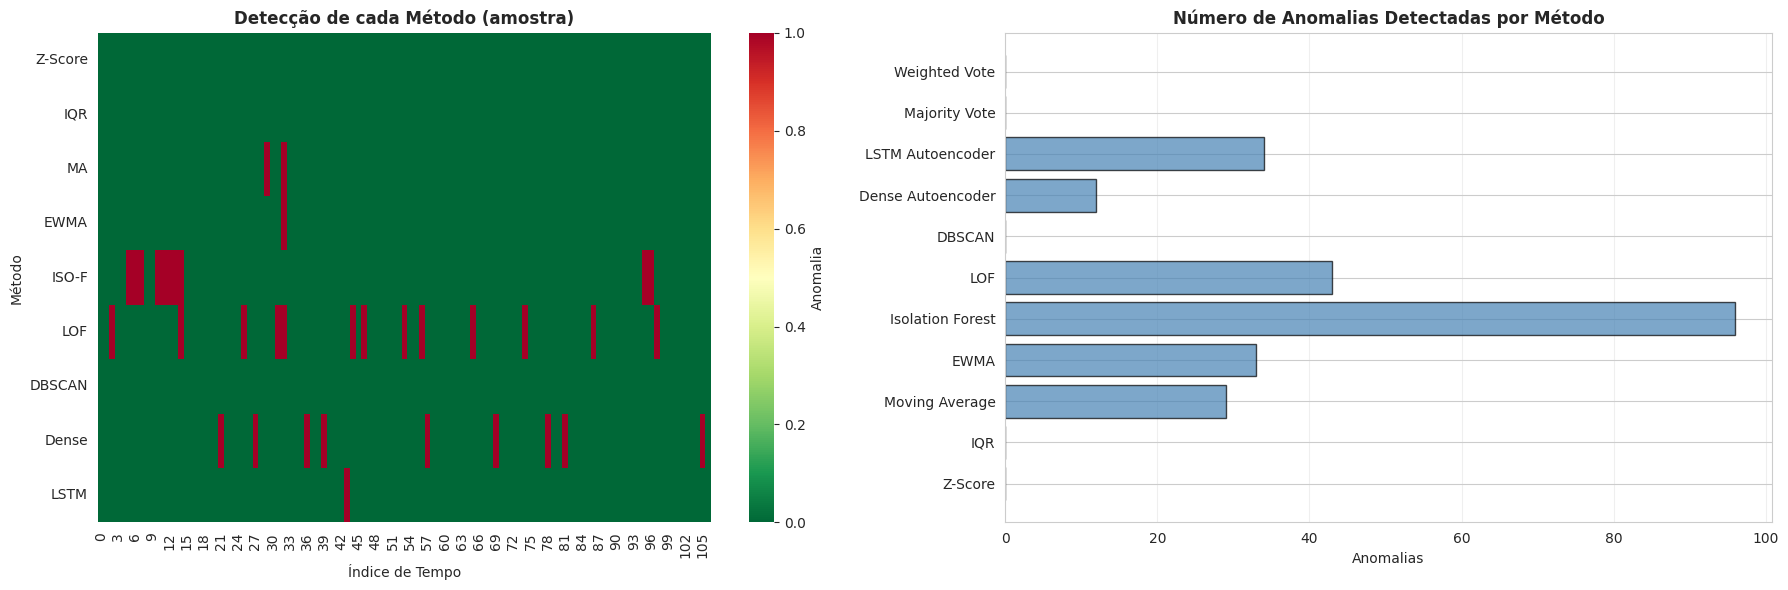

In [11]:
# ## Visualização 1: Heatmap de Consenso

print("\nGerando visualizações...")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap
methods_names = ['Z-Score', 'IQR', 'MA', 'EWMA', 'ISO-F', 'LOF', 'DBSCAN', 'Dense', 'LSTM']
sample_idx = np.arange(0, len(all_predictions), max(1, len(all_predictions)//100))
heatmap_sample = all_predictions[sample_idx]

sns.heatmap(heatmap_sample.T, cmap='RdYlGn_r', cbar_kws={'label': 'Anomalia'}, ax=axes[0])
axes[0].set_title('Detecção de cada Método (amostra)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Índice de Tempo')
axes[0].set_ylabel('Método')
axes[0].set_yticklabels(methods_names, rotation=0)

# Comparação de contagem
colors = ['steelblue']*9 + ['red']*2
axes[1].barh(comparison['Método'], comparison['Anomalias'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Número de Anomalias Detectadas por Método', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Anomalias')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('outputs/plots/06_ensemble_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/06_ensemble_comparison.png")
plt.show()

✓ Salvo: outputs/plots/06_ensemble_timeseries.png


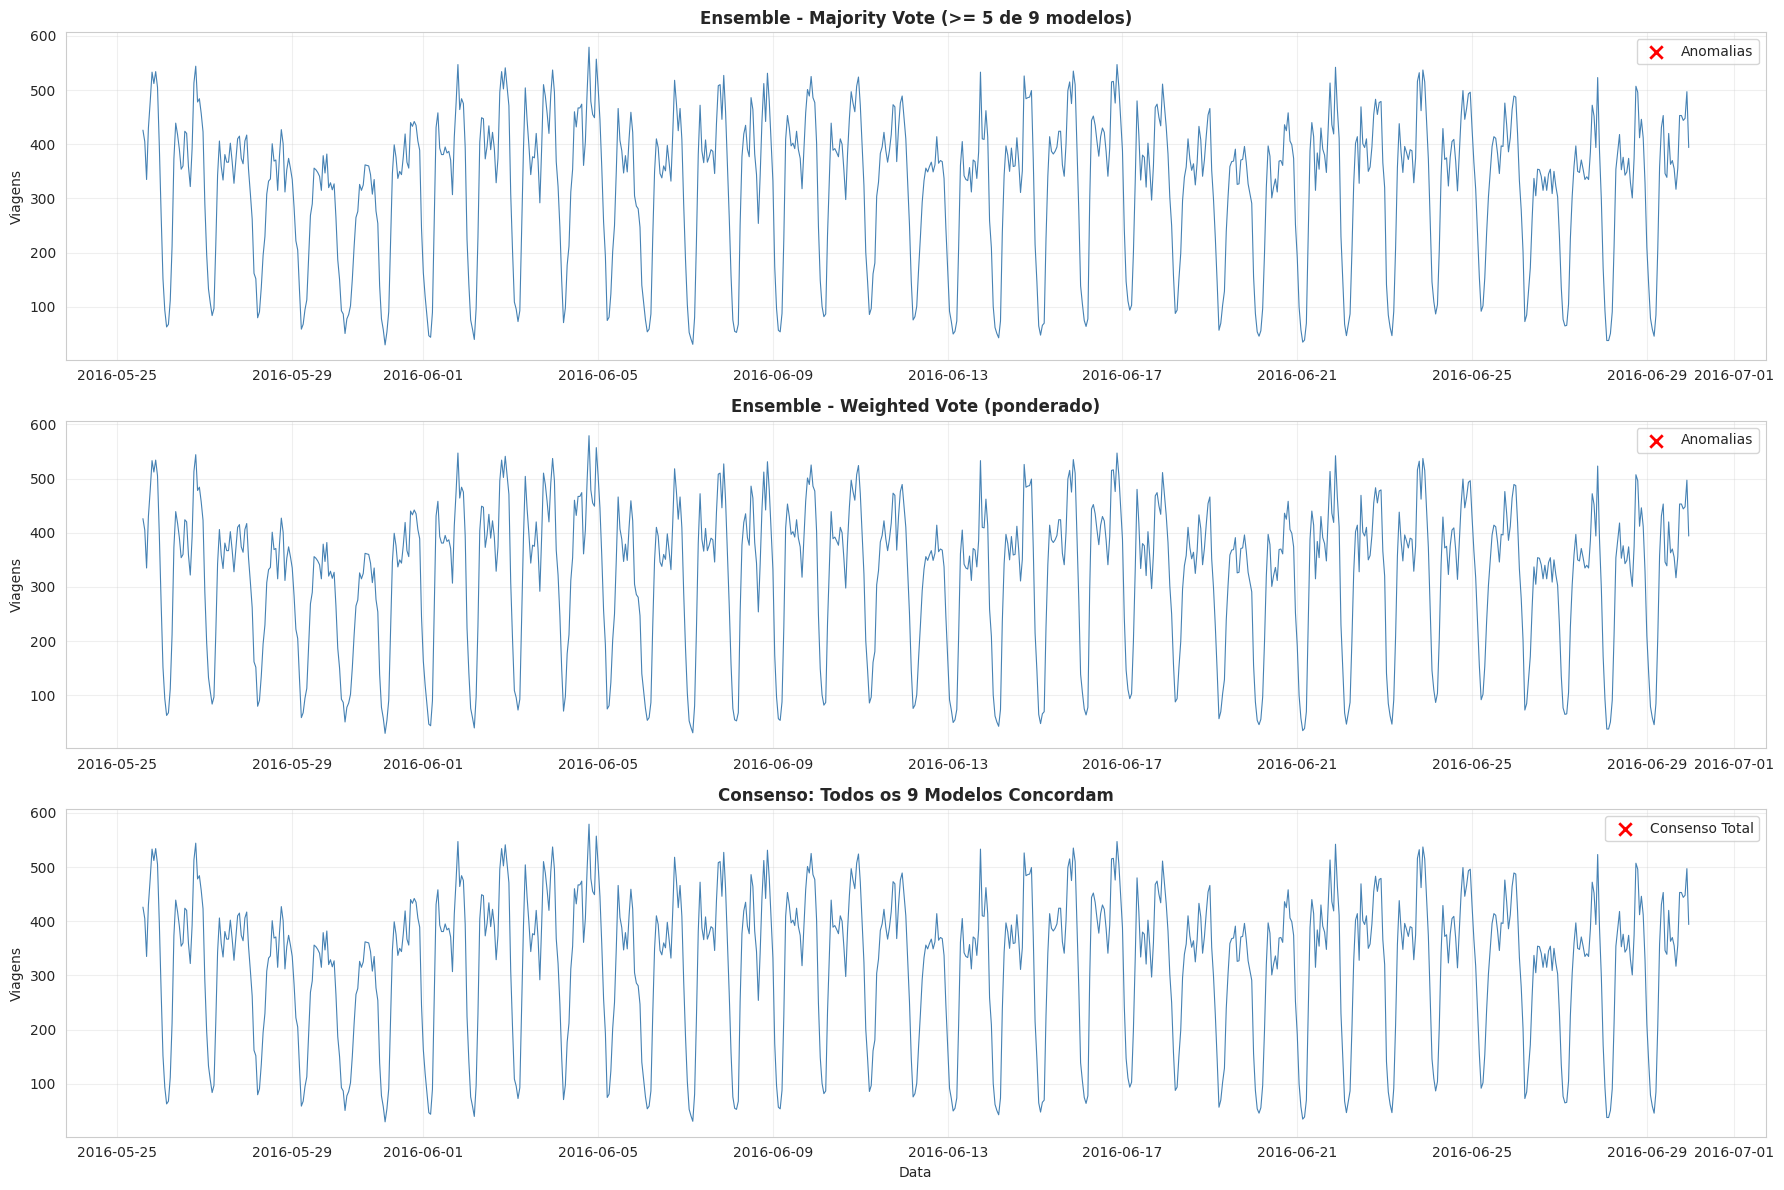

In [12]:
# ## Visualização 2: Série Temporal com Ensemble

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

test_plot = test.iloc[:len(majority_vote)]

# Majority Vote
anomaly_idx_maj = majority_vote == 1
axes[0].plot(test_plot['timestamp'], test_plot['value'], linewidth=0.8, color='steelblue')
axes[0].scatter(test_plot[anomaly_idx_maj]['timestamp'], test_plot[anomaly_idx_maj]['value'],
               color='red', s=80, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[0].set_title('Ensemble - Majority Vote (>= 5 de 9 modelos)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Viagens')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Weighted Vote
anomaly_idx_wei = weighted_vote == 1
axes[1].plot(test_plot['timestamp'], test_plot['value'], linewidth=0.8, color='steelblue')
axes[1].scatter(test_plot[anomaly_idx_wei]['timestamp'], test_plot[anomaly_idx_wei]['value'],
               color='red', s=80, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[1].set_title('Ensemble - Weighted Vote (ponderado)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Viagens')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Consenso
anomaly_idx_cons = consensus == 1
axes[2].plot(test_plot['timestamp'], test_plot['value'], linewidth=0.8, color='steelblue')
axes[2].scatter(test_plot[anomaly_idx_cons]['timestamp'], test_plot[anomaly_idx_cons]['value'],
               color='red', s=80, marker='x', linewidth=2, label='Consenso Total', zorder=5)
axes[2].set_title('Consenso: Todos os 9 Modelos Concordam', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Viagens')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/06_ensemble_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/06_ensemble_timeseries.png")
plt.show()

In [13]:
# ## Salvar Resultados

results = test_plot.copy()
results['zscore'] = zscore_aligned
results['iqr'] = iqr_aligned
results['ma'] = ma_aligned
results['ewma'] = ewma_aligned
results['iso_forest'] = iso_aligned
results['lof'] = lof_aligned
results['dbscan'] = dbscan_aligned
results['dense_ae'] = dense_aligned
results['lstm_ae'] = lstm_aligned
results['majority_vote'] = majority_vote
results['weighted_vote'] = weighted_vote
results['consensus'] = consensus

results.to_csv('outputs/reports/day6_ensemble_results.csv', index=False)
print("✓ Salvo: outputs/reports/day6_ensemble_results.csv")


✓ Salvo: outputs/reports/day6_ensemble_results.csv


In [14]:
# ## Resumo Final

print("\n" + "=" * 70)
print("RESUMO DO DIA 6")
print("=" * 70)

print(f"\n📊 ENSEMBLE RESULTS:")
print(f"  Majority Vote: {majority_vote.sum()} anomalias ({100*majority_vote.sum()/len(majority_vote):.2f}%)")
print(f"  Weighted Vote: {weighted_vote.sum()} anomalias ({100*weighted_vote.sum()/len(weighted_vote):.2f}%)")
print(f"  Consenso Total: {consensus.sum()} anomalias ({100*consensus.sum()/len(consensus):.2f}%)")

print(f"\n🎯 RECOMENDAÇÕES:")
print(f"  • Use Majority Vote pra balance entre sensibilidade e especificidade")
print(f"  • Use Weighted Vote pra dar mais peso aos modelos confiáveis")
print(f"  • Use Consenso pra anomalias críticas (alta confiança)")

print(f"\n✅ MELHORES MÉTODOS:")
top_methods = comparison.nlargest(5, 'Anomalias')
for idx, row in top_methods.iterrows():
    print(f"  {idx+1}. {row['Método']}: {row['Anomalias']} anomalias ({row['Percentual']})")

print("\n" + "=" * 70)
print("✓ DIA 6 CONCLUÍDO!")
print("=" * 70)


RESUMO DO DIA 6

📊 ENSEMBLE RESULTS:
  Majority Vote: 0 anomalias (0.00%)
  Weighted Vote: 0 anomalias (0.00%)
  Consenso Total: 0 anomalias (0.00%)

🎯 RECOMENDAÇÕES:
  • Use Majority Vote pra balance entre sensibilidade e especificidade
  • Use Weighted Vote pra dar mais peso aos modelos confiáveis
  • Use Consenso pra anomalias críticas (alta confiança)

✅ MELHORES MÉTODOS:
  5. Isolation Forest: 96.0 anomalias (10.98%)
  6. LOF: 43.0 anomalias (4.92%)
  9. LSTM Autoencoder: 34.0 anomalias (3.89%)
  4. EWMA: 33.0 anomalias (3.78%)
  3. Moving Average: 29.0 anomalias (3.32%)

✓ DIA 6 CONCLUÍDO!
